# Examine SO Extrema below N=5, 10

In [1]:
# imports
import os
import glob
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from ocpy.utils import plotting

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle
from cugn import defs

# Load CUGN

In [20]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]
grid_tbl = items[3]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


# Examine the quantities

In [29]:
grid_extrem[['profile', 'Nf5', 'Nf10', 'NSO']]

,profile,Nf5,Nf10,NSO
776,32958,32.0,30.0,35.0
777,32959,17.0,17.0,17.0
782,32964,41.0,23.0,42.0
783,32965,12.0,7.0,15.0
784,32966,15.0,13.0,17.0
...,...,...,...,...
60503,38762,21.0,21.0,21.0
60505,38764,14.0,14.0,14.0
60506,38765,12.0,12.0,12.0
78917,38065,NaN,NaN,NaN


## Loop on profiles

In [21]:
profiles = np.unique(grid_extrem.profile)
idx = grid_extrem.profile == profiles[0]
grid_extrem[['Nf5', 'Nf10', 'NSO']][idx]

,Nf5,Nf10,NSO
18840,8.0,8.0,8.0


In [35]:
idx = grid_extrem.profile == 32965
idx0 = int(np.where(idx)[0][0])
grid_extrem.iloc[idx0]

depth                                0
profile                          32965
row                                 22
col                                 20
doxy                        292.036344
mission                       16C06401
mission_profile                    793
MLD                           8.575988
N                            14.133011
zNpeak                         10.4453
zN5                             4.2497
zN10                            7.6652
Nf5                               12.0
Nf10                               7.0
NSO                               15.0
doxy_p                        99.78355
time               2017-03-14 18:54:13
lon                        -118.106223
lat                          33.320505
z                                   10
CT                           14.787911
SA                           33.351972
sigma0                       24.638233
SO                            1.158375
AOU                          39.927658
chla                     

In [38]:
f5s, f10s = [], []
tot_SO, tot_N5, tot_N10 = 0, 0, 0
for profile in profiles:
    idx = grid_extrem.profile == profile
    idx0 = int(np.where(idx)[0][0])
    if np.isnan(grid_extrem.iloc[idx0].NSO):
        continue
    #
    f5s.append(grid_extrem.iloc[idx0].Nf5 /  grid_extrem.iloc[idx0].NSO)
    f10s.append(grid_extrem.iloc[idx0].Nf10 /  grid_extrem.iloc[idx0].NSO)
    #if profile == 32965:
    #    import pdb
    #    pdb.set_trace()
    #
    tot_SO += grid_extrem.iloc[idx0].NSO
    tot_N5 += grid_extrem.iloc[idx0].Nf5
    tot_N10 += grid_extrem.iloc[idx0].Nf10
# Recast
f5s = np.array(f5s)
f10s = np.array(f10s)

In [40]:
f5s.min(), f10s.max(), f10s.min()

(np.float64(0.0), np.float64(1.0), np.float64(0.0))

In [41]:
tot_N5, tot_N10, tot_SO

(np.float64(12891.0), np.float64(10273.0), np.float64(15214.0))

## Examine

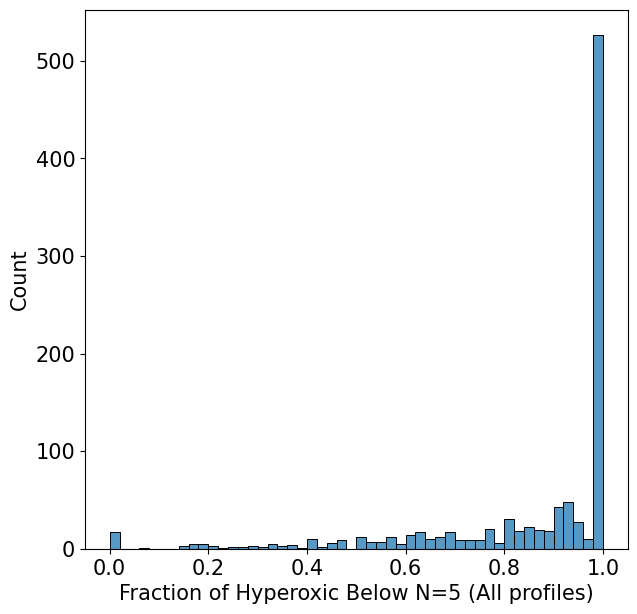

In [44]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
#
sns.histplot(f5s, bins=50)
#ax.set_xlabel(q)
#
#ax.set_ylim(100, 0.)
ax.set_xlabel('Fraction of Hyperoxic Below N=5 (All profiles)')
plotting.set_fontsize(ax, 15.)
#
plt.show()

----

In [52]:
ds.depth

<xarray.DataArray 'depth' (depth: 50)> Size: 200B
array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280,
       290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440, 450, 460, 470, 480, 490, 500], dtype=int32)
Coordinates:
  * depth    (depth) int32 200B 10 20 30 40 50 60 70 ... 450 460 470 480 490 500
Attributes:
    long_name:              Depth
    standard_name:          depth
    units:                  m
    positive:               down
    coverage_content_type:  coordinate

In [74]:
ds_high.latitude.data

array([32.83397  , 32.8326125, 32.8336925, ..., 32.9018675, 32.898075 ,
       32.896155 ])

In [75]:
ds_high

<xarray.Dataset> Size: 203MB
Dimensions:                     (trajectory: 1, profile: 1004, obs: 1104091)
Coordinates:
  * trajectory                  (trajectory) |S19 19B b'sp030-20200513T1702'
  * profile                     (profile) float64 8kB 1.0 2.0 ... 1.004e+03
    time                        (profile) datetime64[ns] 8kB ...
    latitude                    (profile) float64 8kB 32.83 32.83 ... 32.9 32.9
    latitude_uv                 (profile) float64 8kB ...
    longitude                   (profile) float64 8kB ...
    longitude_uv                (profile) float64 8kB ...
    time_uv                     (profile) datetime64[ns] 8kB ...
    depth                       (obs) float64 9MB 0.0397 0.0 ... 2.78 1.867
Dimensions without coordinates: obs
Data variables: (12/54)
    profile_obs_index           (obs) float64 9MB 1.0 1.0 ... 1.004e+03
    row_size                    (profile) int32 4kB ...
    time_qc                     (profile) float64 8kB ...
    latitude_qc                 (profile) float64 8kB ...
    latitude_uv_qc              (profile) float64 8kB ...
    longitude_qc                (profile) float64 8kB ...
    ...                          ...
    gps_end_qc_tests            (profile) float64 8kB ...
    wmo_id                      <U7 28B ...
    instrument_doxy             float64 8B ...
    instrument_ctd              float64 8B ...
    instrument_fchl             float64 8B ...
    platform_meta               float64 8B ...
Attributes: (12/65)
    Conventions:                   CF-1.8, COARDS, ACDD-1.3
    acknowledgement:               Funded by National Oceanic and Atmospheric...
    cdm_profile_variables:         profile,time,latitude,longitude
    cdm_trajectory_variables:      trajectory
    comment:                       This file contains data from the following...
    contributor_name:              Daniel Rudnick, Jennifer Sevadjian
    ...                            ...
    time_coverage_duration:        P0000-03-19T23:09:53
    time_coverage_end:             2020-09-02T16:12:26Z
    time_coverage_resolution:      P0000-00-00T00:00:04
    time_coverage_start:           2020-05-13T17:02:33Z
    title:                         Science Quality Full-Resolution Data from ...
    history:                       2020-09-14T16:18:20Z: KDZ readflasho63(gps...